# 1. 라이브러리 임포트

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [29]:
# 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
from transformers import Trainer, TrainingArguments
import re
import pyarrow as pa
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.model_selection import train_test_split
from datasets import load_metric

# 2. 데이터불러오기 및 EDA

In [5]:
data = pd.read_csv('/content/drive/MyDrive/아이펠톤/DKTC data/train.csv')

In [6]:
data.shape

(3950, 3)

In [7]:
data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [8]:
data['class'].value_counts()

기타 괴롭힘 대화      1094
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
Name: class, dtype: int64

# 3. 데이터 전처리및 타입변경

In [9]:
data.rename(columns={'class':'label'}, inplace=True)

In [10]:
# remove '\n' in sentence
import re
def preprocess(sentence):
    return re.sub('\n', '', sentence)

data['conversation'] = data['conversation'].apply(lambda x: preprocess(x))

In [11]:
label_list = {'기타 괴롭힘 대화':0, '갈취 대화':1, '직장 내 괴롭힘 대화':2, '협박 대화':3}
label_list

{'기타 괴롭힘 대화': 0, '갈취 대화': 1, '직장 내 괴롭힘 대화': 2, '협박 대화': 3}

In [12]:
data['label'] = data['label'].apply(lambda x: label_list[x])

In [13]:
data.head()

,idx,label,conversation
0,0,3,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,3,길동경찰서입니다.9시 40분 마트에 폭발물을 설치할거다.네?똑바로 들어 한번만 더 ...
2,2,0,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.그만해. 니들 놀리는거 재미없어...
3,3,1,어이 거기예??너 말이야 너. 이리 오라고무슨 일.너 옷 좋아보인다?얘 돈 좀 있나...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [14]:
# convert to Huggingface dataset
import pyarrow as pa
from datasets import Dataset

data = Dataset(pa.Table.from_pandas(data))

In [15]:
type(data)

datasets.arrow_dataset.Dataset

In [16]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 4)
# model = AutoModel.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [17]:
def transform(data):
  return tokenizer(
      data['conversation'],
      truncation = True,
      padding = 'max_length',
      return_token_type_ids = True,
      )
  
examples = data[:3]
examples_transformed = transform(examples)

print(examples)
print(examples_transformed)

{'idx': [0, 1, 2], 'label': [3, 3, 0], 'conversation': ['지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게. 정말 잘못했습니다. 너가 선택해. 너가 죽을래 네 가족을 죽여줄까. 죄송합니다. 정말 잘못했습니다. 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야. 선택 못하겠습니다. 한번만 도와주세요. 그냥 다 죽여버려야겠군. 이의 없지? 제발 도와주세요.', '길동경찰서입니다.9시 40분 마트에 폭발물을 설치할거다.네?똑바로 들어 한번만 더 얘기한다.장난전화 걸지 마시죠. 9시 40분 마트에 폭발물이 터지면 다 죽는거야. 장난전화는 업무방해죄에 해당됩니다.판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지.선생님 진정하세요.난 이야기했어. 경고했다는 말이야.', '너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.그만해. 니들 놀리는거 재미없어.지영아 너가 키 160이지? 그럼 재는 160도 안돼는거네?너 군대도 안가고 좋겠다.니들이 나 작은데 보태준거 있냐?난쟁이들도 장가가고하던데. 너도 희망을 가져봐 더이상 하지마라. 그 키크는 수술도 있대잖아? 니네 엄마는 그거 안해주디?나람 해줬어. 저 키로 어찌살아.제발 그만 괴롭히라고!']}
{'input_ids': [[2, 3660, 743, 4201, 2138, 11287, 2448, 7245, 20336, 2205, 2259, 575, 2179, 2116, 35, 6525, 18, 7822, 11800, 18, 1565, 2069, 568, 2460, 4638, 1565, 2118, 3616, 2299, 2118, 3863, 2170, 27063, 2318, 1897, 35, 4229, 11287, 10592, 2088, 1335, 2318, 18, 3944, 4389, 2371, 2219, 3606, 18, 743, 2116, 4

In [18]:
encoded_data = data.map(transform, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [19]:
from sklearn.model_selection import train_test_split
train_dataset, validation_dataset= encoded_data.train_test_split(test_size=0.1).values()

In [20]:
train_dataset

Dataset({
    features: ['idx', 'label', 'conversation', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3555
})

In [21]:
print(len(train_dataset['token_type_ids']))
print(len(train_dataset['label']))
print(len(train_dataset['idx']))
print(len(train_dataset['conversation']))
print(len(train_dataset['attention_mask']))

3555
3555
3555
3555
3555


In [22]:
set(train_dataset['label'])

{0, 1, 2, 3}

In [23]:
validation_dataset

Dataset({
    features: ['idx', 'label', 'conversation', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 395
})

In [24]:
print(len(validation_dataset['token_type_ids']))
print(len(validation_dataset['label']))
print(len(validation_dataset['idx']))
print(len(validation_dataset['conversation']))
print(len(validation_dataset['attention_mask']))

395
395
395
395
395


In [25]:
set(validation_dataset['label'])

{0, 1, 2, 3}

(array([   0.,    0.,    0.,    0.,    0., 3555.,    0.,    0.,    0.,
           0.]),
 array([511.5, 511.6, 511.7, 511.8, 511.9, 512. , 512.1, 512.2, 512.3,
        512.4, 512.5]),
 <a list of 10 Patch objects>)

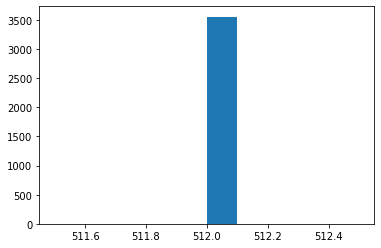

In [26]:
le = []
for s in train_dataset['input_ids']:
    le.append(len(s))

plt.hist(le)

(array([  0.,   0.,   0.,   0.,   0., 395.,   0.,   0.,   0.,   0.]),
 array([511.5, 511.6, 511.7, 511.8, 511.9, 512. , 512.1, 512.2, 512.3,
        512.4, 512.5]),
 <a list of 10 Patch objects>)

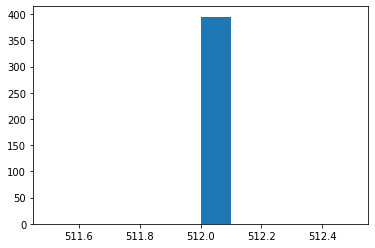

In [37]:
le = []
for s in validation_dataset['input_ids']:
    le.append(len(s))

plt.hist(le)

# 4. 토크나이저, 모델 생성

# 5. Train

In [38]:
# Trainer을 활용하는 형태로 모델 재생성
from transformers import Trainer, TrainingArguments
output_dir = '/content/drive/MyDrive/아이펠톤/any'
metric_name = 'accuracy'

training_arguments = TrainingArguments(
    output_dir, 
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 2e-5, 
    per_device_train_batch_size = 16, 
    per_device_eval_batch_size = 16, 
    num_train_epochs = 3,
    weight_decay = 0.01
)

In [39]:
from datasets import load_metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [40]:
trainer = Trainer(
    model=model,                           
    args=training_arguments,                  
    train_dataset=train_dataset,    
    eval_dataset=validation_dataset,      
    compute_metrics=compute_metrics
)
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, conversation. If idx, conversation are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3555
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 669


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.300715,0.903797
2,No log,0.300425,0.893671
3,0.344200,0.302405,0.924051


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, conversation. If idx, conversation are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 395
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, conversation. If idx, conversation are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 395
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/아이펠톤/any/checkpoint-500
Configuration saved in /content/drive/MyDrive/아이펠톤/any/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/아이펠톤/any/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don'

TrainOutput(global_step=669, training_loss=0.2837871186580002, metrics={'train_runtime': 1055.2593, 'train_samples_per_second': 10.107, 'train_steps_per_second': 0.634, 'total_flos': 2806129794723840.0, 'train_loss': 0.2837871186580002, 'epoch': 3.0})

# F1 score

In [30]:
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 4)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [31]:
metric = load_metric("f1")

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels, average="micro")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


In [33]:
output_dir = '/content/drive/MyDrive/아이펠톤/any'

training_arguments = TrainingArguments(
    output_dir, 
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 2e-5, 
    per_device_train_batch_size = 16, 
    per_device_eval_batch_size = 16, 
    num_train_epochs = 3,
    weight_decay = 0.01
)

In [36]:
trainer = Trainer(
    model=model,                           
    args=training_arguments,                  
    train_dataset=train_dataset,    
    eval_dataset=validation_dataset,      
    compute_metrics=compute_metrics
)
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, conversation. If idx, conversation are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3555
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 669


Epoch,Training Loss,Validation Loss,F1
1,No log,0.374070,0.853165
2,No log,0.275664,0.913924
3,0.375600,0.278403,0.916456


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, conversation. If idx, conversation are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 395
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: idx, conversation. If idx, conversation are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 395
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/아이펠톤/any/checkpoint-500
Configuration saved in /content/drive/MyDrive/아이펠톤/any/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/아이펠톤/any/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set don'

TrainOutput(global_step=669, training_loss=0.31133099486118654, metrics={'train_runtime': 1006.9042, 'train_samples_per_second': 10.592, 'train_steps_per_second': 0.664, 'total_flos': 2806129794723840.0, 'train_loss': 0.31133099486118654, 'epoch': 3.0})